In [233]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

In [234]:
!pip install geopy

In [235]:
data_dir = "~/aiffel/kaggle_kakr_housing/data"

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [236]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [237]:
# 이상치 제거 (랭커 EDA 참고)

train = train.loc[train['id']!=456]
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7259]
train = train.loc[train['id']!=2777]

In [238]:
# target인 price값을 따로 저징

y = train['price']
del train['price']

In [239]:
# train 데이터의 인덱스를 저장해 놓고, 
# concat하여 train/test 데이터 합치기

data = pd.concat((train, test), axis=0)

print(len(train))
print(len(data))

15030
21498


In [240]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

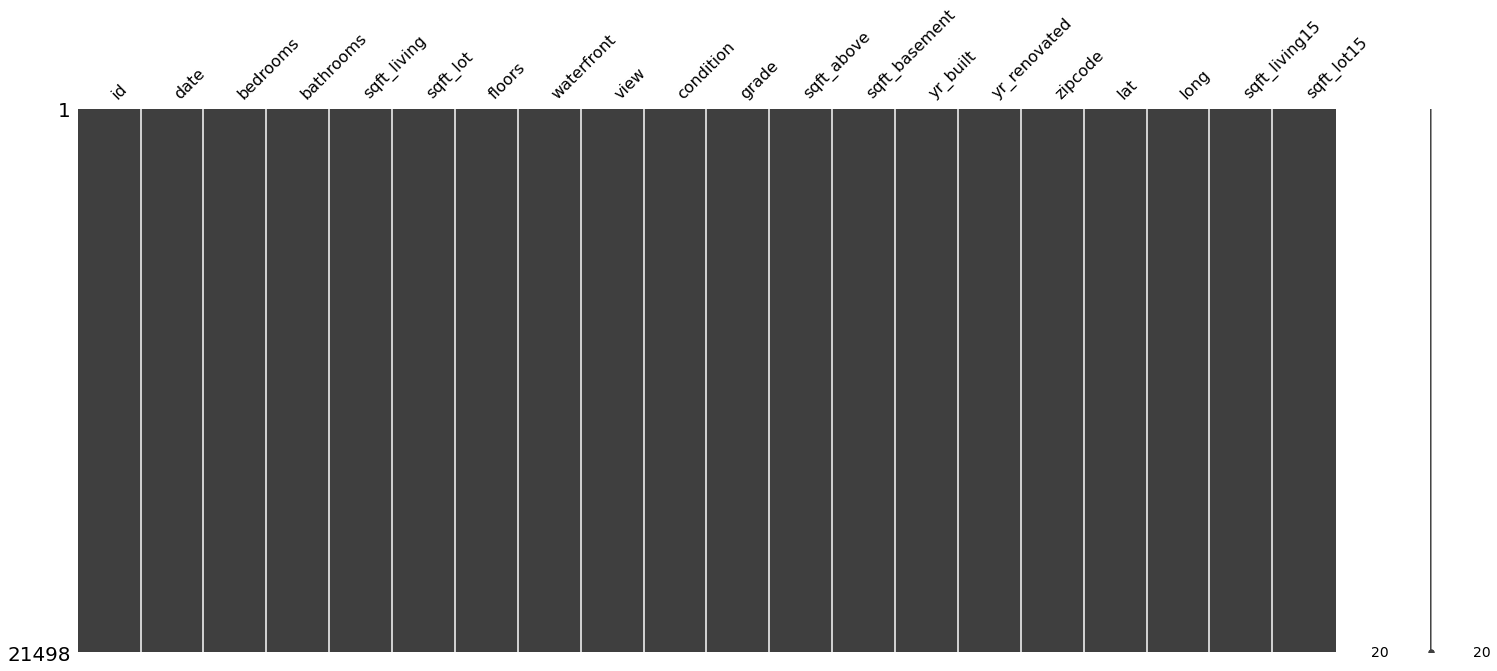

In [241]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [242]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


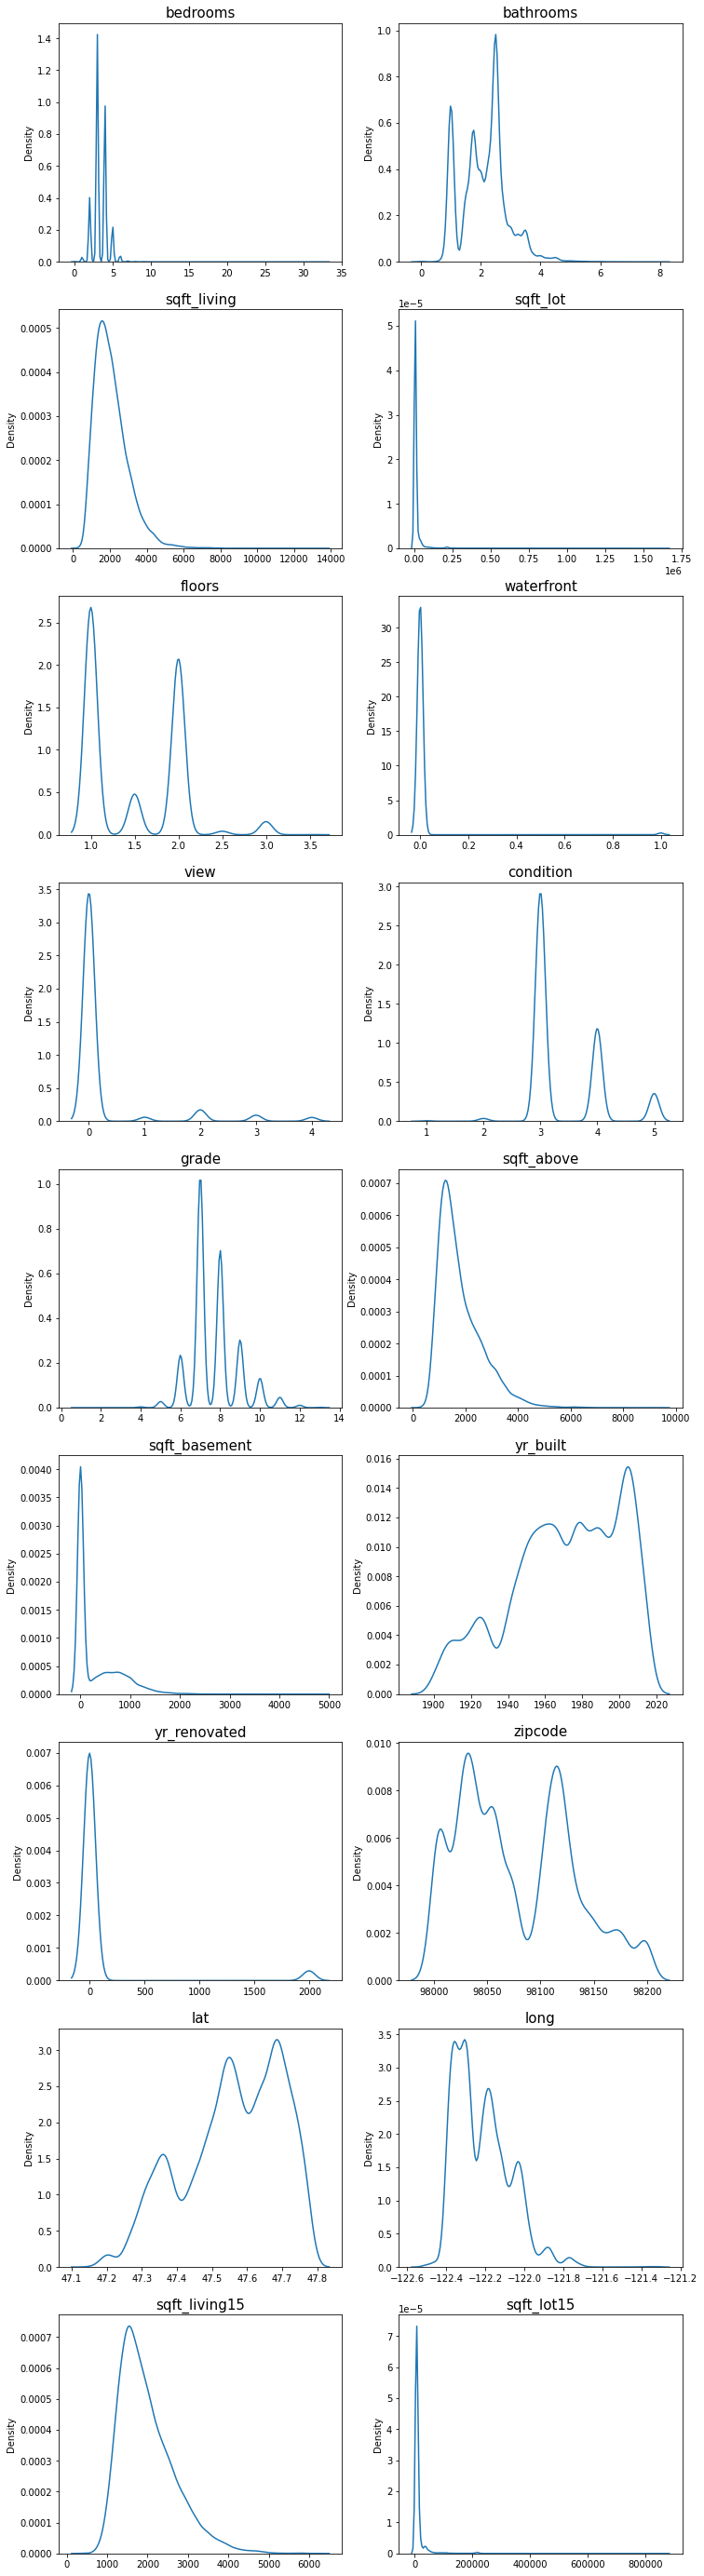

In [243]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는, date object 제외하고 분포를 확인합니다.
columns = data.columns
count = 2

print(columns)
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        ax[row][col].set_xlabel('')  # x축 레이블 제거
        count += 1
        if count == 20 :
            break

### 로그 스케일링
치우친 칼럼을 로그 스케일링 합니다

In [244]:
skew_columns = ['sqft_living', 'sqft_lot','sqft_basement', 'sqft_living15']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

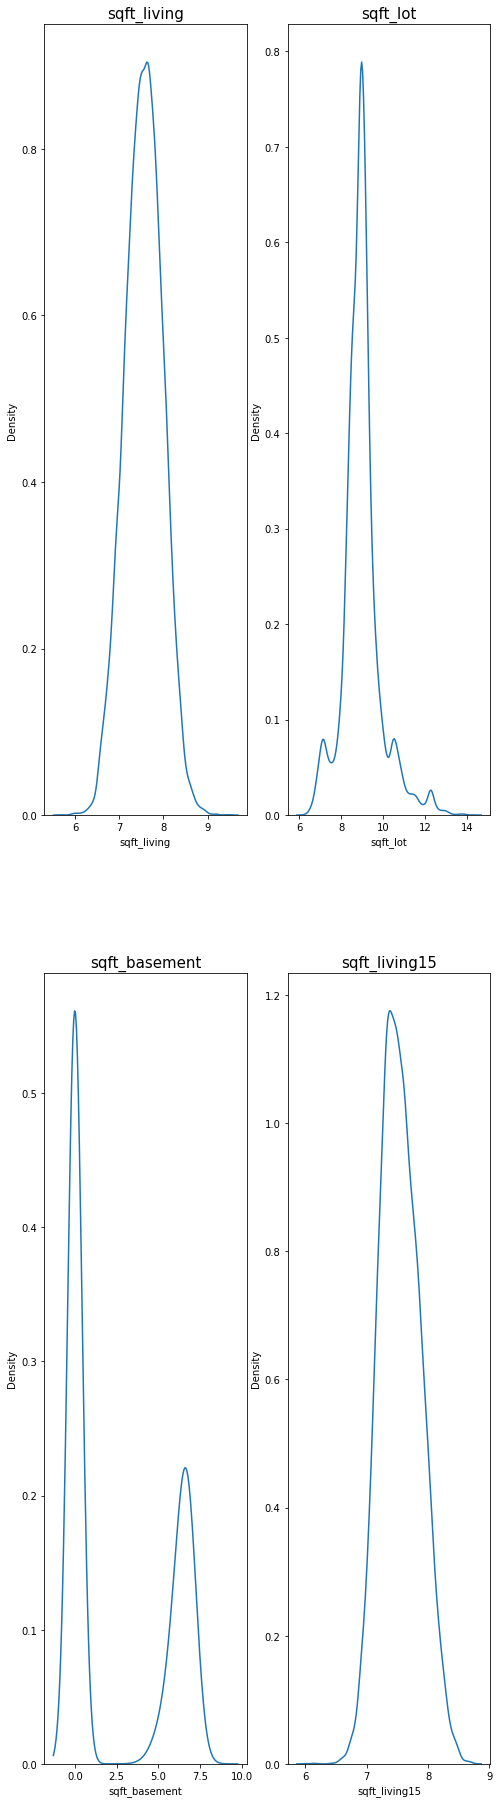

In [245]:
fig, ax = plt.subplots(2, 2, figsize=(8, 32))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
for row in range(2):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 4 :
            break

### feature 조정

- **전체 평수 계산**  
  - `sqft_above`와 `sqft_basement`을 합산하여 `sqft_total_size`를 생성합니다.

- **`date` 칼럼 전처리**  
  - 문자열 형태의 `date` 칼럼을 3개월 단위로 구간화하여, 연도가 2015년이면 `+800`, 그 외에는 `-400`을 적용해 `date(new)`로 만듭니다.

- **리모델링 연도 전처리**  
  - `yr_renovated`가 대부분 0으로 몰려 있으므로, 건물 나이(`how_old`)를 계산할 때 `yr_built`와 `yr_renovated` 중 더 큰 값을 사용합니다.<br>
  - 예: `how_old = (연도) - max(yr_built, yr_renovated)`.

- **건축 연도 스케일 조정**  
  - `yr_built`에서 1900을 빼서 의미 있는 값으로 조정합니다.

- **방의 총 개수**  
  - `bedrooms + bathrooms`로 `total_rooms`를 생성합니다.

- **용적률 계산**  
  - `floor_area_ratio = sqft_living / sqft_lot`을 통해 대지 면적 대비 거주 공간 비율을 나타냅니다.

- **위도(`lat`)와 경도(`long`)의 PCA**  
  - `lat`과 `long`을 PCA로 2차원(`coord_pca1`, `coord_pca2`)으로 압축해 공간적 특성을 반영합니다.

- **KMeans 클러스터링**  
  - `lat`와 `long`을 사용해 32개 지역으로 클러스터링하여 `location_cluster`를 생성합니다.

- **위도와 경도의 합·차**  
  - `latlong_sum = lat + long`, `latlong_diff = lat - long`을 추가해 위치 특성을 강화합니다.

- **도심까지의 거리 계산**  
  - `geopy.distance.geodesic`을 사용해 시애틀 도심(`47.6097, -122.3331`)과의 거리를 `distance_to_city_center`로 계산합니다.

- **리모델링 여부 플래그**  
  - `is_renovated = (yr_renovated > 0)`로 리모델링 여부를 나타내는 이진 변수 생성합니다.

- **대지 면적 대비 지상 면적 비율**  
  - `sqft_above_ratio = sqft_above / sqft_lot`으로, 지상 면적이 대지 면적에서 차지하는 비율을 구합니다.

- **총 면적 대비 지하 면적 비율**  
  - `sqft_basement_ratio = sqft_basement / sqft_total_size`로, 지하 면적이 전체 면적에서 차지하는 비율을 구합니다.

- **조건(`condition`)과 전망(`view`)의 조합**  
  - `view_condition = view * condition`을 통해 두 특성의 상호작용을 반영합니다.

- **물가 근처 여부 플래그**  
  - `is_waterfront = (waterfront > 0).astype(int)`로, 물가(리버뷰 등)에 위치한 지 여부를 나타내는 이진 변수입니다.

- **불필요한 열 삭제**  
  - `del df['date']`, `del df['yr_renovated']`를 통해 최종적으로 사용하지 않는 열을 정리합니다.


In [246]:
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15030, 20)
sub data dim : (6468, 20)


In [247]:
data.shape

(21498, 20)

In [248]:
data['zipcode']

0       98178
1       98028
2       98074
3       98003
4       98198
        ...  
6463    98010
6464    98144
6465    98116
6466    98144
6467    98027
Name: zipcode, Length: 21498, dtype: int64

In [249]:
for df in [train, test]:
    del df['id']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # date 칼럼 3개월씩 범주형으로 나누기
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)
    
    # renovated 칼럼에 0이 너무 많으므로, 변경
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1)
    
    #모두 1900년도 이므로 좀 더 의미를 가지게 변경
    df['yr_built'] = df['yr_built'] - 1900
    
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    #용적률 계산
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    #위도 경도 pca해서 사용
    coord = df[['lat','long']]
    pca = PCA(n_components=2)
    pca.fit(coord)

    coord_pca = pca.transform(coord)

    df['coord_pca1'] = coord_pca[:, 0]
    df['coord_pca2'] = coord_pca[:, 1]
    
    # KMeans 클러스터링
    kmeans = KMeans(n_clusters=32, random_state=42)
    df['location_cluster'] = kmeans.fit_predict(df[['lat', 'long']])
    
    # 위도와 경도의 합과 차
    df['latlong_sum'] = df['lat'] + df['long']
    df['latlong_diff'] = df['lat'] - df['long']

    # 특정 기준점까지의 거리 계산 (예: 도심)
    from geopy.distance import geodesic

    city_center = (47.6097, -122.3331)  # 시애틀 도심 좌표
    df['distance_to_city_center'] = df.apply(lambda x: geodesic((x['lat'], x['long']), city_center).km, axis=1)
    
    # 최근 리모델링 여부 플래그
    df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
    
    # 대지 면적 대비 지상 면적 비율
    df['sqft_above_ratio'] = df['sqft_above'] / df['sqft_lot']

    # 총 면적 대비 지하 면적 비율
    df['sqft_basement_ratio'] = df['sqft_basement'] / df['sqft_total_size']

    # 조건과 전망의 조합
    df['view_condition'] = df['view'] * df['condition']

    # 물가 근처 여부 플래그
    df['is_waterfront'] = (df['waterfront'] > 0).astype(int)
    
    del df['date']
    del df['yr_renovated']

In [250]:
train.shape

(15030, 33)

In [251]:
test.shape

(6468, 33)

In [252]:
print('Columns in train but not in test:', set(train.columns) - set(test.columns))
print('Columns in test but not in train:', set(test.columns) - set(train.columns))

Columns in train but not in test: set()
Columns in test but not in train: set()


In [253]:
# 지역별 집값 평균, 분산 계산 후 추가
train['price'] = y
train['per_price'] = train['price'] / train['sqft_total_size']

In [254]:
print(train['sqft_total_size'])

0        1180
1         770
2        1680
3        1715
4        1060
         ... 
15030    2520
15031    3510
15032    1530
15033    2310
15034    1020
Name: sqft_total_size, Length: 15030, dtype: int64


In [255]:
# GroupBy로 zipcode별 평균(mean)과 분산(var) 계산
zipcode_price = train.groupby(['zipcode'])['per_price'].agg(mean='mean', var='var').reset_index()

# train 데이터에 병합
train = pd.merge(train, zipcode_price, how='left', on='zipcode')

# test 데이터에 병합
test = pd.merge(test, zipcode_price, how='left', on='zipcode')

In [256]:
for df in [train,test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']
    del df['zipcode']

In [257]:
del train['price']
del train['per_price']

In [258]:
data = pd.concat((train, test), axis=0)

In [259]:
train.shape

(15030, 34)

In [260]:
test.shape

(6468, 34)

In [261]:
train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'sqft_total_size', 'date(new)', 'how_old', 'total_rooms',
       'floor_area_ratio', 'coord_pca1', 'coord_pca2', 'location_cluster',
       'latlong_sum', 'latlong_diff', 'distance_to_city_center',
       'is_renovated', 'sqft_above_ratio', 'sqft_basement_ratio',
       'view_condition', 'is_waterfront', 'zipcode_mean', 'zipcode_var'],
      dtype='object')

In [264]:
print(x_train.isnull().sum())  # 각 열별 결측값 개수

bedrooms                   0
bathrooms                  0
sqft_living                0
sqft_lot                   0
floors                     0
waterfront                 0
view                       0
condition                  0
grade                      0
sqft_above                 0
sqft_basement              0
yr_built                   0
lat                        0
long                       0
sqft_living15              0
sqft_lot15                 0
sqft_total_size            0
date(new)                  0
how_old                    0
total_rooms                0
floor_area_ratio           0
coord_pca1                 0
coord_pca2                 0
location_cluster           0
latlong_sum                0
latlong_diff               0
distance_to_city_center    0
sqft_per_room              0
is_renovated               0
sqft_above_ratio           0
sqft_basement_ratio        0
view_condition             0
is_waterfront              0
zipcode_mean               0
zipcode_var   

In [265]:
inf_cols = x_train.columns[np.isinf(x_train).any()]
print("Columns with Inf:", inf_cols)

Columns with Inf: Index(['sqft_per_room'], dtype='object')


## 3. 모델링
### Eensemble

이전에 그리드 서치로 찾은 파라미터를 바탕으로 앙상블을 진행한다.

In [266]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, StackingRegressor 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

In [267]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    train, y, test_size=0.2, random_state=42
)

In [268]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    colsample_bytree=0.4,
    gamma=0.0468,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1.7817,
    n_estimators=10000,
    reg_alpha=0.4640,
    reg_lambda=0.8571,
    subsample=0.8,
    random_state=25,
    n_jobs=-1,           
    verbosity=2       
)


from lightgbm import LGBMRegressor

model_lgb = LGBMRegressor(
    objective='regression',
    num_leaves=15, 
    learning_rate=0.05,
    n_estimators=10000,
    max_bin=80,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.2319,
    random_state=25,
    min_data_in_leaf=6,
    min_sum_hessian_in_leaf=11,
    verbosity=2,   
    n_jobs=-1
)

from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor(
    n_estimators= 10000,         # 부스팅 반복 횟수
    learning_rate=0.05,         # 학습률
    max_depth=4,                # 트리 최대 깊이
    max_features='sqrt',        # 피처 샘플링 (sqrt는 제곱근 개수만큼 사용)
    min_samples_leaf=15,        # 리프 노드의 최소 샘플 수
    min_samples_split=10,       # 노드 분할 최소 샘플 수
    loss='huber',               # Huber 손실 (이상치에 강건)
    random_state=25,             # 재현성
    verbose = 100
)

In [273]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

# 1. Voting Regressor 정의
voting_model = VotingRegressor(
    estimators=[
        ('xgb', model_xgb),
        ('lgb', model_lgb),
        ('gb', model_gb)
    ]
)

# 2. 모델 학습
voting_model.fit(x_train, y_train)

[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned

[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned n

[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 prun

[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned n

[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned n

[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 prun

[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned 

[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 prune

[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 prune

[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 prun

[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 prun

[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned n

[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned

[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 prune

[17:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned

[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned

[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned n

[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned

[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned 

[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pru

[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned 

[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned

[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pru

[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 prune

[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned 

[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned 

[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 prune

[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned 

[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 prun

[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned

[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned no

[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned n

[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned 

[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned n

[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned

[17:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[17:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned

[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned 

[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned 

[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned

[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned n

[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned n

[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned

[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned 

[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned no

[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned

[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 prune

[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned 

[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned no

[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned

[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned 

[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned n

[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 prune

[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned

[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned

[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 prune

[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned 

[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned n

[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned 

[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned 

[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned 

[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned 

[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned no

[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned n

[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned 

[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned

[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned n

[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 prune

[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned

[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned no

[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned 

[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned n

[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned

[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned no

[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned n

[17:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned

[17:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned n

[17:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:54:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned

[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 prun

[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned

[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned

[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned 

[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned

[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned 

[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned

[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned 

[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned n

[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 prune

[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned

[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned n

[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned n

[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned n

[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned no

[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned 

[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned n

[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned 

[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned n

[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[17:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned 

[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned 

[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned 

[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned n

[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned n

[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 prune

[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned 

[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned no

[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned n

[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned 

[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned 

[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned no

[17:55:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned

[17:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned n

[17:55:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:55:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned 

[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned

[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned n

[17:55:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned 

[17:55:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:55:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned 

[17:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:55:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:55:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned n

[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned

[17:55:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:55:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[17:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned n

[17:55:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:55:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[17:55:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:55:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned

[17:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned

[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned n

[17:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned 

[17:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned 

[17:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:56:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:56:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned 

[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 prune

[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned 

[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned n

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9531 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 a

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9521 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9597 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9600 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9687 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9655 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9635 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9642 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9582 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9645 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Re-bagging, using 9620 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9605

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9672 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9588 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9617 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9629 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9647 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 a

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9644 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9681 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with le

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9604 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9600 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 960

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9650 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9599 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9603 data to train
[LightGBM] [Debug] Trained a tree with leaves = 1

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9684 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9584 

[LightGBM] [Debug] Re-bagging, using 9718 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9677 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9592 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9637 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9615 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leav

[LightGBM] [Debug] Re-bagging, using 9618 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9679 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9547 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 1

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9631 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9661 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with le

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9543 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9579 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9647 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9561 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9604 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9591 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9687 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9628 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 1

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9587 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9542 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9606 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9618 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9530 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9600 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Re-bagging, using 9657 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9611 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9636 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9579

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9660 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9661 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 a

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9568 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9574 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9699 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9639 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9594 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 967

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9601 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9653 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leav

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9582 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9625 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with le

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 12
[LightGBM] [Debug] Re-bagging, using 9575 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9585 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with le

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9648 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9610 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9706 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9494 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9626 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leav

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9575 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9670 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9591 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9734 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9662 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9621 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9596 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9655 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9646 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9677 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9550 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Re-bagging, using 9628 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Re-bagging, using 9709 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9609 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 1

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9620 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9577 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9542 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9597 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9556 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9571 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9629 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9611 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 a

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9578 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9612 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leav

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9656 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9668 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9654 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9667 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9660 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 1

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9649 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9681 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with le

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9644 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9713 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9563 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 a

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Re-bagging, using 9565 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9568 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9589 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9653 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9693 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 1

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9694 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9644 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9637

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9627 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9680 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9717 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9602 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9629 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9661 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9605 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9603 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 a

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9569 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Re-bagging, using 9637 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with le

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9636 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9676 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Re-bagging, using 9613 d

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Re-bagging, using 9636 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Re-bagging, using 9581 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Re-bagging, using 9650 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 

       147  3892886263.1667            4.10m
       148  3879967109.4008            4.10m
       149  3876629502.3208            4.10m
       150  3870005142.1298            4.09m
       151  3856393417.9149            4.10m
       152  3852643367.4747            4.11m
       153  3842097605.6799            4.11m
       154  3835217810.6981            4.11m
       155  3818962846.6623            4.11m
       156  3811335660.6566            4.11m
       157  3807293456.7101            4.11m
       158  3800934131.7430            4.11m
       159  3794142825.3901            4.10m
       160  3781265971.1520            4.11m
       161  3772760951.8008            4.11m
       162  3768831064.2372            4.10m
       163  3761961779.1971            4.10m
       164  3752330573.0233            4.10m
       165  3739933270.3318            4.10m
       166  3735377910.4432            4.10m
       167  3723227438.8686            4.10m
       168  3712108621.3198            4.11m
       169

       333  2965830534.5382            3.93m
       334  2963409751.2926            3.93m
       335  2959915917.0573            3.93m
       336  2955712339.0689            3.93m
       337  2952897521.2353            3.93m
       338  2947991739.8254            3.93m
       339  2943021118.8382            3.93m
       340  2941197671.0267            3.93m
       341  2941211725.9705            3.93m
       342  2938410416.4904            3.93m
       343  2936799754.3079            3.93m
       344  2934756754.5975            3.93m
       345  2932089713.8667            3.94m
       346  2929725071.4724            3.94m
       347  2925381977.9371            3.94m
       348  2922296940.3262            3.94m
       349  2919250886.3335            3.94m
       350  2913092792.9346            3.94m
       351  2909095638.6997            3.94m
       352  2906790065.7667            3.94m
       353  2905364771.3374            3.94m
       354  2903169243.6593            3.93m
       355

       517  2545400301.6877            3.93m
       518  2545271019.4695            3.93m
       519  2541964995.0326            3.93m
       520  2542612213.2116            3.93m
       521  2541400598.3218            3.92m
       522  2538895186.7243            3.92m
       523  2536382989.7571            3.92m
       524  2532324445.1299            3.92m
       525  2530711995.2788            3.92m
       526  2530151767.2900            3.92m
       527  2527519351.0076            3.92m
       528  2523138473.0366            3.92m
       529  2521867054.7141            3.92m
       530  2520960730.6680            3.92m
       531  2519982748.3363            3.92m
       532  2517630582.2902            3.92m
       533  2516487102.3811            3.91m
       534  2515598098.6632            3.91m
       535  2514539949.4273            3.91m
       536  2512993385.7911            3.91m
       537  2510901050.2851            3.91m
       538  2508975747.6281            3.91m
       539

       705  2277393988.4277            3.82m
       706  2277113326.9970            3.82m
       707  2276419665.5379            3.82m
       708  2274664939.0127            3.81m
       709  2274343538.4414            3.81m
       710  2272409057.7838            3.81m
       711  2269966493.8943            3.81m
       712  2268718522.8792            3.81m
       713  2267509597.0692            3.81m
       714  2266202583.2145            3.81m
       715  2264894008.8224            3.81m
       716  2262255791.1929            3.81m
       717  2261522834.0779            3.81m
       718  2261411319.9340            3.81m
       719  2259817041.3962            3.81m
       720  2258597135.1018            3.81m
       721  2257325666.4050            3.81m
       722  2257293159.0720            3.81m
       723  2256548584.0459            3.81m
       724  2254473814.7717            3.80m
       725  2254096974.5662            3.80m
       726  2253091436.3716            3.80m
       727

       893  2087097399.3409            3.72m
       894  2085288712.7496            3.72m
       895  2083931114.8072            3.72m
       896  2082992357.8609            3.72m
       897  2081824900.9594            3.72m
       898  2080925102.1424            3.72m
       899  2080431273.1391            3.72m
       900  2079836585.7720            3.72m
       901  2078041359.8109            3.72m
       902  2077402313.7832            3.71m
       903  2075892647.1590            3.71m
       904  2073883502.8728            3.72m
       905  2072844084.3958            3.72m
       906  2071859159.2819            3.72m
       907  2068911229.5748            3.72m
       908  2067921204.1301            3.71m
       909  2067214051.6905            3.71m
       910  2066835136.1276            3.71m
       911  2068276742.0296            3.71m
       912  2067917552.1184            3.71m
       913  2066549906.3438            3.71m
       914  2063752421.5418            3.71m
       915

      1080  1930493312.9662            3.60m
      1081  1929171981.0281            3.60m
      1082  1928919952.6790            3.60m
      1083  1928283075.0168            3.60m
      1084  1928237736.8846            3.60m
      1085  1927520918.9225            3.60m
      1086  1926334492.1169            3.60m
      1087  1924404135.3753            3.59m
      1088  1923693681.6185            3.59m
      1089  1923029507.3790            3.59m
      1090  1922744282.8489            3.59m
      1091  1920741403.2559            3.59m
      1092  1919803505.3945            3.59m
      1093  1918052629.1179            3.59m
      1094  1917347133.7904            3.59m
      1095  1915730326.5272            3.59m
      1096  1913661543.3493            3.59m
      1097  1913403020.9901            3.59m
      1098  1912976463.8160            3.59m
      1099  1912681361.3722            3.59m
      1100  1911990931.2472            3.59m
      1101  1911292623.6131            3.59m
      1102

      1266  1815427778.0770            3.50m
      1267  1815207998.6163            3.50m
      1268  1814533713.2361            3.50m
      1269  1814460244.8381            3.50m
      1270  1813208319.9037            3.50m
      1271  1812158958.2352            3.50m
      1272  1811987029.2329            3.50m
      1273  1811525828.2080            3.50m
      1274  1811068468.0830            3.50m
      1275  1810163527.1765            3.50m
      1276  1810456456.2414            3.50m
      1277  1810201485.2348            3.50m
      1278  1809982045.7152            3.50m
      1279  1810384551.9401            3.50m
      1280  1809299880.7302            3.50m
      1281  1808791857.0353            3.50m
      1282  1808190439.8160            3.50m
      1283  1808092658.8715            3.50m
      1284  1807686446.8319            3.49m
      1285  1807366054.9144            3.49m
      1286  1807176583.4632            3.49m
      1287  1807171105.8058            3.49m
      1288

      1456  1728703212.1659            3.40m
      1457  1728050378.9039            3.39m
      1458  1727403911.2933            3.39m
      1459  1727047559.5204            3.39m
      1460  1726990361.1684            3.39m
      1461  1726764600.7134            3.39m
      1462  1726330891.3259            3.39m
      1463  1725400593.1480            3.39m
      1464  1725330750.0119            3.39m
      1465  1724818629.4036            3.39m
      1466  1724684820.6691            3.39m
      1467  1724418570.6203            3.39m
      1468  1723853054.2867            3.39m
      1469  1723514038.3625            3.39m
      1470  1723037845.3103            3.39m
      1471  1722922978.3651            3.39m
      1472  1722609171.4709            3.39m
      1473  1722354623.0810            3.39m
      1474  1722069975.1992            3.39m
      1475  1721758970.4362            3.39m
      1476  1721560814.7997            3.39m
      1477  1721347192.5976            3.38m
      1478

      1646  1647230415.5782            3.31m
      1647  1646974911.2843            3.31m
      1648  1646775081.2958            3.31m
      1649  1645291489.2089            3.31m
      1650  1645462285.0988            3.31m
      1651  1644851241.3754            3.31m
      1652  1644830617.1060            3.31m
      1653  1643893651.3439            3.31m
      1654  1643749517.1778            3.31m
      1655  1642831402.8399            3.31m
      1656  1642069666.1003            3.31m
      1657  1642482416.5720            3.30m
      1658  1641927210.2607            3.30m
      1659  1640932548.0637            3.30m
      1660  1640677171.6226            3.30m
      1661  1640776586.8399            3.30m
      1662  1639926812.6847            3.30m
      1663  1639305087.7598            3.30m
      1664  1638843172.3599            3.30m
      1665  1638831296.8075            3.30m
      1666  1638780917.3624            3.30m
      1667  1638135014.3024            3.30m
      1668

      1829  1577854469.3592            3.23m
      1830  1577834135.9890            3.23m
      1831  1577289598.8986            3.23m
      1832  1576228177.5170            3.23m
      1833  1576110307.5250            3.23m
      1834  1575623836.4791            3.23m
      1835  1575373473.6310            3.23m
      1836  1575242337.8210            3.23m
      1837  1574555366.0484            3.23m
      1838  1574626042.1787            3.23m
      1839  1574510891.9642            3.23m
      1840  1574075644.3122            3.23m
      1841  1573967803.7853            3.23m
      1842  1573046794.4783            3.22m
      1843  1572817012.2817            3.22m
      1844  1572707126.0554            3.22m
      1845  1571840541.9791            3.22m
      1846  1571130009.0086            3.22m
      1847  1570806053.8542            3.22m
      1848  1570474855.7193            3.22m
      1849  1570951156.0281            3.22m
      1850  1569802221.4543            3.22m
      1851

      2014  1508822831.5617            3.15m
      2015  1508219169.9650            3.15m
      2016  1508463250.4683            3.15m
      2017  1507716811.6194            3.15m
      2018  1507630171.7213            3.15m
      2019  1507227022.6117            3.15m
      2020  1507086383.4793            3.15m
      2021  1507163107.6096            3.15m
      2022  1506938674.5032            3.15m
      2023  1506802045.4231            3.15m
      2024  1506629146.8588            3.15m
      2025  1506015143.7167            3.15m
      2026  1505240134.1213            3.15m
      2027  1505115326.4723            3.15m
      2028  1504815603.5280            3.15m
      2029  1504898332.4251            3.15m
      2030  1504663068.9697            3.15m
      2031  1504306159.6857            3.15m
      2032  1503817214.0075            3.15m
      2033  1503601235.5693            3.15m
      2034  1503450520.8013            3.15m
      2035  1502763745.2358            3.15m
      2036

      2198  1454196340.4665            3.07m
      2199  1453223410.9375            3.07m
      2200  1452600149.5546            3.07m
      2201  1452377658.8512            3.07m
      2202  1452200162.2467            3.07m
      2203  1451969771.8747            3.07m
      2204  1451361932.5102            3.07m
      2205  1451362360.4098            3.07m
      2206  1451301282.1964            3.07m
      2207  1451096759.0172            3.07m
      2208  1451034148.2119            3.07m
      2209  1450869371.0100            3.07m
      2210  1451676505.6017            3.07m
      2211  1450837356.4159            3.07m
      2212  1450389736.6615            3.07m
      2213  1449415698.6450            3.07m
      2214  1448442253.7048            3.07m
      2215  1448005446.1306            3.07m
      2216  1448029839.9635            3.07m
      2217  1447544732.7509            3.07m
      2218  1447492486.2924            3.07m
      2219  1447461601.1363            3.07m
      2220

      2383  1401114245.1416            3.00m
      2384  1401037790.7975            2.99m
      2385  1398823154.7208            2.99m
      2386  1398762840.0419            2.99m
      2387  1398759693.1482            2.99m
      2388  1398976333.2628            2.99m
      2389  1398666706.0488            2.99m
      2390  1398651801.9938            2.99m
      2391  1398482247.0439            2.99m
      2392  1398342367.2199            2.99m
      2393  1398538251.8487            2.99m
      2394  1398416959.5576            2.99m
      2395  1398402839.2614            2.99m
      2396  1398277119.1158            2.99m
      2397  1398151666.5811            2.99m
      2398  1397799392.1175            2.99m
      2399  1396164116.9326            2.99m
      2400  1396963004.0279            2.99m
      2401  1396452486.7407            2.99m
      2402  1395191024.0865            2.98m
      2403  1395472039.7755            2.98m
      2404  1395275676.2881            2.98m
      2405

      2569  1346831813.2700            2.92m
      2570  1347123402.5249            2.92m
      2571  1346281969.2667            2.92m
      2572  1346236410.8649            2.91m
      2573  1345680912.7810            2.91m
      2574  1344914809.7068            2.91m
      2575  1344565268.2472            2.91m
      2576  1344456950.9388            2.91m
      2577  1343978884.9330            2.91m
      2578  1343607615.3957            2.91m
      2579  1343465850.6330            2.91m
      2580  1343051464.0766            2.91m
      2581  1342781969.1389            2.91m
      2582  1341942235.5596            2.91m
      2583  1341467665.8589            2.91m
      2584  1341339520.2603            2.91m
      2585  1341305412.2533            2.91m
      2586  1341226369.7300            2.91m
      2587  1341202968.3621            2.91m
      2588  1341048952.0654            2.91m
      2589  1340661935.5382            2.91m
      2590  1340139099.7230            2.91m
      2591

      2757  1302891340.5887            2.83m
      2758  1302490920.0228            2.83m
      2759  1302405752.1932            2.83m
      2760  1301879092.4391            2.83m
      2761  1301810511.4306            2.83m
      2762  1301726570.0668            2.83m
      2763  1301595584.8090            2.83m
      2764  1301338481.6663            2.83m
      2765  1301272846.1928            2.83m
      2766  1301119839.5631            2.83m
      2767  1300969083.0611            2.83m
      2768  1300993500.0724            2.83m
      2769  1300962166.2498            2.83m
      2770  1300770027.1172            2.83m
      2771  1300657572.8957            2.83m
      2772  1300474256.3181            2.83m
      2773  1300314627.2319            2.83m
      2774  1300160899.6387            2.83m
      2775  1300127859.7361            2.83m
      2776  1299716265.7663            2.83m
      2777  1299556818.8809            2.83m
      2778  1299542549.4090            2.83m
      2779

      2947  1267133645.1348            2.75m
      2948  1267026651.5223            2.75m
      2949  1267056662.5817            2.75m
      2950  1266775223.0617            2.75m
      2951  1266196464.8309            2.75m
      2952  1265809258.2369            2.75m
      2953  1265604150.0561            2.75m
      2954  1265201620.1169            2.75m
      2955  1264614037.7399            2.75m
      2956  1264467836.3678            2.75m
      2957  1264343334.7710            2.75m
      2958  1263958953.5153            2.75m
      2959  1262832520.0865            2.75m
      2960  1262562347.0648            2.75m
      2961  1262410165.6992            2.75m
      2962  1262362160.9161            2.74m
      2963  1262046712.5039            2.74m
      2964  1262052101.8279            2.74m
      2965  1261886042.0104            2.74m
      2966  1261744945.6698            2.74m
      2967  1261571747.5982            2.74m
      2968  1261548023.5092            2.74m
      2969

      3134  1222452357.9819            2.67m
      3135  1222207745.4256            2.67m
      3136  1221801424.1793            2.67m
      3137  1220985866.1925            2.67m
      3138  1220843822.1582            2.67m
      3139  1220815921.7088            2.67m
      3140  1220619165.6049            2.67m
      3141  1220367191.0325            2.67m
      3142  1220368267.2887            2.67m
      3143  1220009448.4993            2.67m
      3144  1219956254.6469            2.67m
      3145  1219790474.7280            2.67m
      3146  1219628006.0293            2.67m
      3147  1219507585.0550            2.67m
      3148  1219410052.7199            2.67m
      3149  1219120507.6960            2.67m
      3150  1219009892.9387            2.67m
      3151  1219002590.0897            2.67m
      3152  1218094652.6146            2.67m
      3153  1218125939.7038            2.67m
      3154  1217961655.8782            2.67m
      3155  1217636735.6412            2.66m
      3156

      3324  1179009724.4726            2.59m
      3325  1178807588.9540            2.59m
      3326  1178745343.5981            2.59m
      3327  1178548364.1298            2.59m
      3328  1178474779.5349            2.59m
      3329  1178409631.2685            2.59m
      3330  1178305126.6458            2.59m
      3331  1178049547.4066            2.59m
      3332  1177516534.9051            2.59m
      3333  1177632275.7887            2.59m
      3334  1177617001.7757            2.59m
      3335  1177521974.1841            2.59m
      3336  1177484234.1271            2.59m
      3337  1177445779.8413            2.59m
      3338  1177433055.3034            2.59m
      3339  1177208090.4628            2.59m
      3340  1176649572.6799            2.59m
      3341  1176875932.1193            2.59m
      3342  1176529018.0134            2.59m
      3343  1176423532.6012            2.58m
      3344  1176091111.5689            2.58m
      3345  1176474471.1383            2.58m
      3346

      3511  1138961527.5410            2.52m
      3512  1139048282.5009            2.52m
      3513  1138826530.9451            2.52m
      3514  1138729509.7360            2.52m
      3515  1138372900.6479            2.52m
      3516  1138110111.7630            2.52m
      3517  1138175899.4295            2.52m
      3518  1137557540.0635            2.52m
      3519  1137527468.8299            2.51m
      3520  1137232765.3889            2.51m
      3521  1136879105.8402            2.51m
      3522  1136405369.5538            2.51m
      3523  1136155632.6481            2.51m
      3524  1135838101.7619            2.51m
      3525  1135477294.5451            2.51m
      3526  1135259413.6677            2.51m
      3527  1134983077.4175            2.51m
      3528  1134739682.1279            2.51m
      3529  1134613758.6412            2.51m
      3530  1134393935.1236            2.51m
      3531  1134097336.8847            2.51m
      3532  1133923681.8659            2.51m
      3533

      3696  1092252227.0483            2.45m
      3697  1091717312.4906            2.45m
      3698  1091562471.3026            2.45m
      3699  1091701763.1957            2.45m
      3700  1091563189.6103            2.45m
      3701  1091507878.2242            2.44m
      3702  1091402970.1892            2.44m
      3703  1091458355.6050            2.44m
      3704  1091300792.8614            2.44m
      3705  1091140096.8573            2.44m
      3706  1091003194.3963            2.44m
      3707  1090743116.7965            2.44m
      3708  1090608212.8396            2.44m
      3709  1090372228.0280            2.44m
      3710  1090178858.2160            2.44m
      3711  1090111729.5806            2.44m
      3712  1089954626.3654            2.44m
      3713  1089912280.7486            2.44m
      3714  1089685473.8265            2.44m
      3715  1089521423.7415            2.44m
      3716  1089331548.3804            2.44m
      3717  1089161404.8323            2.44m
      3718

      3880  1047998675.0497            2.38m
      3881  1047835902.4202            2.38m
      3882  1047648756.5562            2.38m
      3883  1047390727.6123            2.38m
      3884  1047212791.6248            2.38m
      3885  1047012666.4790            2.38m
      3886  1046966005.8421            2.38m
      3887  1046765452.6300            2.38m
      3888  1046580579.2445            2.38m
      3889  1046470653.2301            2.38m
      3890  1046238411.1175            2.38m
      3891  1045960991.0905            2.38m
      3892  1045728494.9339            2.38m
      3893  1045441456.3288            2.37m
      3894  1045105808.9165            2.37m
      3895  1044902924.4664            2.37m
      3896  1044801937.9819            2.37m
      3897  1044667906.9139            2.37m
      3898  1044565216.0672            2.37m
      3899  1044252782.3215            2.37m
      3900  1044180078.0044            2.37m
      3901  1043943880.1083            2.37m
      3902

      4065  1007953482.9510            2.31m
      4066  1007845650.3700            2.31m
      4067  1007668760.4454            2.31m
      4068  1007478040.9573            2.31m
      4069  1007150607.3509            2.31m
      4070  1006977094.3487            2.31m
      4071  1006474223.3082            2.31m
      4072  1006272847.9641            2.31m
      4073  1006010710.8592            2.31m
      4074  1005788909.6820            2.30m
      4075  1005733400.4374            2.30m
      4076  1005541727.6390            2.30m
      4077  1005403269.2679            2.30m
      4078  1005082536.4869            2.30m
      4079  1004972185.1184            2.30m
      4080  1004941816.8827            2.30m
      4081  1004788724.8298            2.30m
      4082  1004340651.6436            2.30m
      4083  1003981701.7989            2.30m
      4084  1004217285.1557            2.30m
      4085  1004083307.3814            2.30m
      4086  1003901908.5714            2.30m
      4087

      4250   974986214.2808            2.24m
      4251   974940188.4299            2.23m
      4252   974801053.2084            2.23m
      4253   974747499.9003            2.23m
      4254   974272014.6888            2.23m
      4255   974207175.8736            2.23m
      4256   974148242.5842            2.23m
      4257   974086778.2986            2.23m
      4258   973873145.9709            2.23m
      4259   973830598.9346            2.23m
      4260   973753943.1948            2.23m
      4261   973574303.5043            2.23m
      4262   973290351.5710            2.23m
      4263   973332389.7961            2.23m
      4264   973151121.0777            2.23m
      4265   972827634.3423            2.23m
      4266   972489614.2394            2.23m
      4267   972094904.5043            2.23m
      4268   971983330.3069            2.23m
      4269   971900017.8167            2.23m
      4270   971713694.4731            2.23m
      4271   971591776.9225            2.23m
      4272

      4435   937537524.7104            2.16m
      4436   937462448.9998            2.16m
      4437   937385733.5213            2.16m
      4438   937190998.7125            2.16m
      4439   937015874.8385            2.16m
      4440   936898482.4392            2.16m
      4441   936698659.4644            2.16m
      4442   936592758.1293            2.16m
      4443   936410791.0165            2.16m
      4444   936096772.7091            2.16m
      4445   935944902.6771            2.16m
      4446   935317749.5527            2.16m
      4447   935009272.2561            2.16m
      4448   935065722.3276            2.16m
      4449   934940497.8682            2.16m
      4450   934812649.5570            2.16m
      4451   934439254.2142            2.16m
      4452   934370145.6436            2.16m
      4453   934240603.1667            2.16m
      4454   934153053.4260            2.16m
      4455   933640508.3685            2.16m
      4456   933450067.9699            2.15m
      4457

      4623   900967642.5752            2.09m
      4624   900805619.3456            2.09m
      4625   900825882.3305            2.09m
      4626   900582747.1655            2.09m
      4627   899961648.5628            2.09m
      4628   899822756.6824            2.09m
      4629   899630485.3437            2.09m
      4630   899439191.2970            2.09m
      4631   899123916.4530            2.09m
      4632   899176743.9050            2.09m
      4633   899066333.8548            2.09m
      4634   898986407.0468            2.09m
      4635   898774238.6445            2.09m
      4636   898392654.7308            2.09m
      4637   898228017.2231            2.09m
      4638   898137144.7239            2.09m
      4639   898092621.2712            2.09m
      4640   897857962.4212            2.09m
      4641   897749449.3291            2.09m
      4642   897274698.0885            2.09m
      4643   896814431.5812            2.09m
      4644   896689123.1882            2.09m
      4645

      4814   867817950.3580            2.02m
      4815   867761512.7175            2.02m
      4816   867562662.7547            2.02m
      4817   867334458.7183            2.02m
      4818   867249688.7506            2.02m
      4819   867043272.0301            2.02m
      4820   866923115.9461            2.02m
      4821   866766381.2897            2.02m
      4822   866500693.0536            2.02m
      4823   866298091.0174            2.02m
      4824   865797165.2501            2.01m
      4825   865819501.8044            2.01m
      4826   865742597.8004            2.01m
      4827   865411181.9605            2.01m
      4828   865069955.0751            2.01m
      4829   864928369.3225            2.01m
      4830   864768995.5879            2.01m
      4831   864710888.2023            2.01m
      4832   864672218.1751            2.01m
      4833   864419259.5317            2.01m
      4834   864326110.2465            2.01m
      4835   864203639.0262            2.01m
      4836

      4999   836938524.4194            1.95m
      5000   836936024.6125            1.95m
      5001   836901710.0906            1.94m
      5002   836738647.3194            1.94m
      5003   836622177.1983            1.94m
      5004   836576932.9538            1.94m
      5005   836487963.9484            1.94m
      5006   836481359.0778            1.94m
      5007   836323401.0026            1.94m
      5008   835887757.2180            1.94m
      5009   835800618.3672            1.94m
      5010   836067655.4031            1.94m
      5011   835873093.1219            1.94m
      5012   835555200.2630            1.94m
      5013   835414726.1020            1.94m
      5014   835349365.1952            1.94m
      5015   835161795.1192            1.94m
      5016   834734463.4877            1.94m
      5017   834364499.2128            1.94m
      5018   834229440.8260            1.94m
      5019   834166173.4154            1.94m
      5020   834136511.8558            1.94m
      5021

      5183   809430026.2707            1.87m
      5184   809541845.5273            1.87m
      5185   809409175.8539            1.87m
      5186   809314015.9056            1.87m
      5187   809198489.3523            1.87m
      5188   809099430.4912            1.87m
      5189   808838295.9234            1.87m
      5190   807839844.8820            1.87m
      5191   807692612.7389            1.87m
      5192   807581897.9010            1.87m
      5193   807664731.4328            1.87m
      5194   807612714.1403            1.87m
      5195   807531568.6062            1.87m
      5196   807236174.0329            1.87m
      5197   807208841.9078            1.87m
      5198   807197428.8969            1.87m
      5199   807056562.8341            1.87m
      5200   806946251.8425            1.87m
      5201   806885951.8997            1.87m
      5202   806682222.3647            1.87m
      5203   807047951.4722            1.87m
      5204   807000288.1437            1.87m
      5205

      5366   786226881.1177            1.80m
      5367   786105501.5832            1.80m
      5368   785928645.3220            1.80m
      5369   785881019.3534            1.80m
      5370   785941358.5878            1.80m
      5371   785921322.6932            1.80m
      5372   785809889.5284            1.80m
      5373   785757711.3854            1.80m
      5374   785606710.4437            1.80m
      5375   785557838.7064            1.80m
      5376   785496199.0838            1.80m
      5377   785498419.2020            1.80m
      5378   785408495.7048            1.80m
      5379   785042523.5462            1.80m
      5380   784862796.8814            1.80m
      5381   784828057.0556            1.80m
      5382   784700428.6718            1.80m
      5383   784948537.0141            1.80m
      5384   784796828.3941            1.80m
      5385   784636712.0663            1.80m
      5386   784523049.0230            1.80m
      5387   784439119.1144            1.80m
      5388

      5550   763585833.1333            1.74m
      5551   763472199.0736            1.74m
      5552   763378152.5522            1.74m
      5553   763304756.5279            1.74m
      5554   763293894.0982            1.74m
      5555   763287840.3391            1.74m
      5556   763231576.8233            1.74m
      5557   763108459.0691            1.74m
      5558   763083942.9486            1.74m
      5559   763038149.3037            1.73m
      5560   762934468.9071            1.73m
      5561   762797965.7802            1.73m
      5562   762545701.6087            1.73m
      5563   762415510.4095            1.73m
      5564   762296556.7107            1.73m
      5565   762201402.6176            1.73m
      5566   761972271.0632            1.73m
      5567   761820427.0202            1.73m
      5568   761683557.6023            1.73m
      5569   761718153.6580            1.73m
      5570   761643351.8193            1.73m
      5571   761326160.8581            1.73m
      5572

      5739   742726501.1110            1.66m
      5740   742663602.5508            1.66m
      5741   742633477.0500            1.66m
      5742   742489130.4130            1.66m
      5743   742411754.7989            1.66m
      5744   742343152.2326            1.66m
      5745   742153848.1477            1.66m
      5746   742100352.9690            1.66m
      5747   741978993.2501            1.66m
      5748   741616954.7243            1.66m
      5749   741548172.6936            1.66m
      5750   741366065.0231            1.66m
      5751   741214132.2637            1.66m
      5752   741123501.7217            1.66m
      5753   741047895.9762            1.66m
      5754   740975013.1679            1.66m
      5755   740877991.9708            1.66m
      5756   741014972.2086            1.66m
      5757   740905365.2836            1.66m
      5758   740541734.9141            1.66m
      5759   740289483.4114            1.66m
      5760   740171728.9819            1.66m
      5761

      5928   715611310.5799            1.59m
      5929   715406463.1695            1.59m
      5930   715563093.0491            1.59m
      5931   715586909.0650            1.59m
      5932   715551390.3341            1.59m
      5933   715426956.7598            1.59m
      5934   715438439.7797            1.59m
      5935   714734190.5947            1.59m
      5936   715151740.7498            1.59m
      5937   715102390.7455            1.59m
      5938   714979159.4306            1.59m
      5939   714595177.3254            1.59m
      5940   714534840.7224            1.59m
      5941   714371462.2163            1.59m
      5942   713831237.6975            1.59m
      5943   713977138.7545            1.58m
      5944   713995475.4574            1.58m
      5945   713914860.0186            1.58m
      5946   713871925.0903            1.58m
      5947   713778764.0171            1.58m
      5948   713747079.6193            1.58m
      5949   713439010.9407            1.58m
      5950

      6118   695262813.0531            1.52m
      6119   694563780.1595            1.52m
      6120   694512691.6458            1.52m
      6121   694377164.3759            1.52m
      6122   694610839.6327            1.52m
      6123   694427495.2878            1.51m
      6124   694121983.9902            1.51m
      6125   693979504.9721            1.51m
      6126   693924166.9918            1.51m
      6127   693920006.7104            1.51m
      6128   693822850.0228            1.51m
      6129   693845241.1605            1.51m
      6130   693677652.7826            1.51m
      6131   693601124.1301            1.51m
      6132   693611095.9250            1.51m
      6133   693576183.8905            1.51m
      6134   693386183.7949            1.51m
      6135   692882534.1231            1.51m
      6136   692627745.9767            1.51m
      6137   692512420.7663            1.51m
      6138   692440654.5373            1.51m
      6139   692542425.8163            1.51m
      6140

      6307   674763511.8433            1.44m
      6308   674782110.8492            1.44m
      6309   674727684.2159            1.44m
      6310   674628772.2510            1.44m
      6311   674432171.9732            1.44m
      6312   674395942.1540            1.44m
      6313   674281577.2730            1.44m
      6314   674149863.6927            1.44m
      6315   673984221.8024            1.44m
      6316   673517517.0201            1.44m
      6317   673357916.5638            1.44m
      6318   673205353.7201            1.44m
      6319   673220171.8688            1.44m
      6320   673014773.7866            1.44m
      6321   672921425.7584            1.44m
      6322   672804229.1481            1.44m
      6323   672608330.3900            1.44m
      6324   672537202.4638            1.44m
      6325   672445315.8071            1.44m
      6326   672345697.5156            1.43m
      6327   672117449.9705            1.43m
      6328   672025830.1191            1.43m
      6329

      6498   652625069.1290            1.37m
      6499   652531005.6748            1.37m
      6500   652480928.9396            1.37m
      6501   652285721.5436            1.37m
      6502   652244933.4886            1.37m
      6503   652133105.8723            1.37m
      6504   651335033.6585            1.37m
      6505   651283506.0203            1.36m
      6506   651122492.0028            1.36m
      6507   651147714.9640            1.36m
      6508   651013773.4977            1.36m
      6509   650821070.3160            1.36m
      6510   650751762.3958            1.36m
      6511   651223048.6957            1.36m
      6512   651143257.7502            1.36m
      6513   651091768.3047            1.36m
      6514   650986834.8740            1.36m
      6515   650901786.0332            1.36m
      6516   650807204.5642            1.36m
      6517   650720873.8266            1.36m
      6518   650613231.6993            1.36m
      6519   650470253.3714            1.36m
      6520

      6687   634498753.7598            1.29m
      6688   634418332.9017            1.29m
      6689   634298163.7375            1.29m
      6690   632754884.9160            1.29m
      6691   632679423.0849            1.29m
      6692   632418190.0618            1.29m
      6693   632355676.6561            1.29m
      6694   632250001.3891            1.29m
      6695   632176829.0799            1.29m
      6696   632120834.3879            1.29m
      6697   632109498.4456            1.29m
      6698   632023205.4526            1.29m
      6699   631874019.6455            1.29m
      6700   631807279.2776            1.29m
      6701   630616659.9516            1.29m
      6702   630690913.2426            1.29m
      6703   630631184.8357            1.29m
      6704   630571725.3836            1.29m
      6705   630558876.0733            1.29m
      6706   630442708.2777            1.29m
      6707   630428145.6275            1.29m
      6708   630307644.0529            1.29m
      6709

      6873   614338156.4296            1.22m
      6874   614303467.5012            1.22m
      6875   614226616.7125            1.22m
      6876   614133321.6811            1.22m
      6877   614056935.9521            1.22m
      6878   614022257.4342            1.22m
      6879   613994574.4772            1.22m
      6880   613975101.4014            1.22m
      6881   613954542.8589            1.22m
      6882   613946068.5084            1.22m
      6883   613918427.9900            1.22m
      6884   613831613.8778            1.22m
      6885   613789625.9406            1.22m
      6886   613775526.8691            1.22m
      6887   613748921.2395            1.22m
      6888   613643349.8723            1.22m
      6889   613653570.2440            1.22m
      6890   613527744.1730            1.22m
      6891   613394682.3798            1.22m
      6892   612618779.7037            1.22m
      6893   612586772.6879            1.22m
      6894   612461174.4677            1.21m
      6895

      7058   596418909.5354            1.15m
      7059   596207173.3270            1.15m
      7060   596119831.4756            1.15m
      7061   596012927.6890            1.15m
      7062   595970017.3928            1.15m
      7063   595995542.2820            1.15m
      7064   595965867.4117            1.15m
      7065   596055828.6208            1.15m
      7066   596027587.7996            1.15m
      7067   595961442.8818            1.15m
      7068   595874529.4241            1.15m
      7069   595763798.8548            1.15m
      7070   595677851.2024            1.15m
      7071   595653877.6369            1.15m
      7072   595644005.9114            1.15m
      7073   595597841.2655            1.14m
      7074   595552602.7727            1.14m
      7075   595473811.3360            1.14m
      7076   595356369.7735            1.14m
      7077   595112731.4729            1.14m
      7078   594867966.6375            1.14m
      7079   594723494.0107            1.14m
      7080

      7243   580843048.1190            1.08m
      7244   580749919.4739            1.08m
      7245   580531009.8278            1.08m
      7246   580438959.2018            1.08m
      7247   580391153.2998            1.08m
      7248   580278445.2195            1.08m
      7249   580018861.6328            1.08m
      7250   579982331.4848            1.08m
      7251   579910941.3029            1.08m
      7252   579959179.4679            1.08m
      7253   579893982.8389            1.08m
      7254   579792721.5107            1.08m
      7255   579661610.1203            1.07m
      7256   579672832.4883            1.07m
      7257   579424685.8932            1.07m
      7258   579554657.7983            1.07m
      7259   579444038.4334            1.07m
      7260   579457736.5177            1.07m
      7261   579424082.1809            1.07m
      7262   579308705.2217            1.07m
      7263   578965182.7055            1.07m
      7264   578942637.0196            1.07m
      7265

      7428   566231312.9404            1.01m
      7429   566163527.9986            1.01m
      7430   566175269.8574            1.01m
      7431   566169846.4156            1.01m
      7432   566132863.5797            1.01m
      7433   566041738.8453            1.00m
      7434   565812289.1993            1.00m
      7435   565715800.0649            1.00m
      7436   565443814.1941            1.00m
      7437   565346605.2509            1.00m
      7438   565322717.0473            1.00m
      7439   565210978.5987            1.00m
      7440   564942192.0325            1.00m
      7441   565047242.0615            1.00m
      7442   564772182.8078            1.00m
      7443   564703307.6819            1.00m
      7444   564684111.6753            1.00m
      7445   564420776.5901           60.00s
      7446   564475581.7398           59.98s
      7447   564369728.1260           59.95s
      7448   564418439.4415           59.93s
      7449   564332726.3900           59.91s
      7450

      7614   549276596.4624           56.07s
      7615   549237363.9620           56.04s
      7616   549232565.8617           56.02s
      7617   549241181.5152           55.99s
      7618   549189380.2911           55.97s
      7619   549003676.8712           55.95s
      7620   548921556.2832           55.92s
      7621   548901208.6558           55.90s
      7622   548838338.1269           55.87s
      7623   548626877.9718           55.85s
      7624   548258009.4408           55.83s
      7625   548196087.3037           55.80s
      7626   548144135.5294           55.78s
      7627   548145790.6823           55.75s
      7628   548091192.4098           55.73s
      7629   548049053.8033           55.71s
      7630   547994465.8171           55.68s
      7631   547977946.5778           55.66s
      7632   547846902.7118           55.64s
      7633   547877226.1749           55.62s
      7634   547807861.4908           55.59s
      7635   547563828.0719           55.57s
      7636

      7803   534621632.5125           51.65s
      7804   534541063.0863           51.62s
      7805   534330100.8056           51.60s
      7806   534240614.4002           51.58s
      7807   534155577.4973           51.55s
      7808   534069639.7245           51.53s
      7809   534058155.4328           51.50s
      7810   533987038.7744           51.48s
      7811   533747015.5986           51.46s
      7812   533682736.2288           51.43s
      7813   533564616.0577           51.41s
      7814   533512735.9865           51.39s
      7815   533422001.3612           51.36s
      7816   533439743.7868           51.34s
      7817   533370019.2408           51.31s
      7818   533337287.6591           51.29s
      7819   533311225.7582           51.27s
      7820   533280630.5810           51.24s
      7821   533059599.6707           51.22s
      7822   533093208.4713           51.19s
      7823   533044415.7632           51.17s
      7824   533001614.5357           51.15s
      7825

      7988   518700146.2584           47.29s
      7989   518719494.8366           47.27s
      7990   518703482.7861           47.25s
      7991   518643272.7721           47.22s
      7992   518614977.4177           47.20s
      7993   518592186.3983           47.18s
      7994   518504509.3511           47.15s
      7995   518475920.2474           47.13s
      7996   518378358.8413           47.11s
      7997   518260021.9697           47.09s
      7998   518327738.4746           47.06s
      7999   518244708.2220           47.04s
      8000   518187216.6417           47.02s
      8001   518169312.7627           46.99s
      8002   518078714.1572           46.97s
      8003   517982938.7051           46.95s
      8004   517562193.6615           46.92s
      8005   517341643.4422           46.90s
      8006   517243525.4580           46.88s
      8007   517133911.5335           46.85s
      8008   517062014.3649           46.83s
      8009   517080559.1818           46.81s
      8010

      8177   506555311.4054           42.86s
      8178   506474573.7211           42.84s
      8179   506449384.5632           42.81s
      8180   506283449.7457           42.79s
      8181   506188419.6350           42.77s
      8182   506145690.2498           42.74s
      8183   506032469.0564           42.72s
      8184   505946442.7113           42.70s
      8185   505964348.6939           42.67s
      8186   505940441.2457           42.65s
      8187   505876930.1261           42.62s
      8188   505804054.9757           42.60s
      8189   505685283.8509           42.58s
      8190   505578736.3815           42.55s
      8191   504989993.9688           42.53s
      8192   504966234.4206           42.51s
      8193   504689585.8678           42.48s
      8194   504683066.3655           42.46s
      8195   504596018.4477           42.44s
      8196   505023051.8926           42.41s
      8197   504984067.8008           42.39s
      8198   504937261.6395           42.36s
      8199

      8366   492745135.5988           38.44s
      8367   492694106.4174           38.42s
      8368   492624459.3027           38.40s
      8369   492675287.0301           38.37s
      8370   492645595.4524           38.35s
      8371   492589712.4422           38.32s
      8372   492573862.1028           38.30s
      8373   492459904.1803           38.28s
      8374   492252406.5564           38.25s
      8375   492224763.3732           38.23s
      8376   492197756.1988           38.21s
      8377   492119288.6953           38.18s
      8378   492109547.4011           38.16s
      8379   492090987.5377           38.14s
      8380   492057286.5170           38.11s
      8381   491962533.1168           38.09s
      8382   491934547.9127           38.06s
      8383   491926646.3551           38.04s
      8384   491790532.8513           38.02s
      8385   491756941.7521           37.99s
      8386   491790869.2346           37.97s
      8387   491790344.9429           37.95s
      8388

      8556   481892818.3683           34.01s
      8557   481849840.2872           33.99s
      8558   481842749.9687           33.96s
      8559   481848377.9695           33.94s
      8560   481780855.1447           33.92s
      8561   481681005.5524           33.90s
      8562   481710416.9750           33.87s
      8563   481638047.4103           33.85s
      8564   481611953.4653           33.82s
      8565   481553931.0270           33.80s
      8566   481538595.2513           33.78s
      8567   481513441.1490           33.75s
      8568   481385974.8296           33.73s
      8569   481340938.2239           33.71s
      8570   481308903.1802           33.68s
      8571   481310307.6047           33.66s
      8572   481291857.3529           33.64s
      8573   481294083.9896           33.61s
      8574   481239554.3326           33.59s
      8575   481234605.6912           33.56s
      8576   481222070.2432           33.54s
      8577   481137078.1203           33.52s
      8578

      8745   470689274.5948           29.56s
      8746   470650231.5593           29.54s
      8747   470499502.5206           29.52s
      8748   470510231.4072           29.49s
      8749   470431456.2745           29.47s
      8750   470353816.6210           29.45s
      8751   470261700.8668           29.42s
      8752   470059279.0261           29.40s
      8753   470158182.2947           29.38s
      8754   470070343.5304           29.35s
      8755   470061167.6296           29.33s
      8756   470053127.6330           29.31s
      8757   469987684.5437           29.28s
      8758   469903828.2268           29.26s
      8759   469952535.2325           29.23s
      8760   469894448.2780           29.21s
      8761   469796728.7361           29.19s
      8762   469675714.5122           29.16s
      8763   469649595.9678           29.14s
      8764   469637729.6808           29.12s
      8765   469566803.6465           29.09s
      8766   469525113.3783           29.07s
      8767

      8928   460423089.5496           25.25s
      8929   460412792.0944           25.23s
      8930   460364475.2457           25.20s
      8931   460324436.8587           25.18s
      8932   460310693.3074           25.16s
      8933   460252501.0774           25.13s
      8934   460238530.2592           25.11s
      8935   460200598.0814           25.09s
      8936   460116097.7836           25.06s
      8937   460156860.5205           25.04s
      8938   460085889.6363           25.02s
      8939   459911642.3735           24.99s
      8940   459904948.7436           24.97s
      8941   459882004.8745           24.94s
      8942   459842027.4565           24.92s
      8943   459824990.9247           24.90s
      8944   459859007.4150           24.87s
      8945   459840611.9165           24.85s
      8946   459840848.9425           24.83s
      8947   459817669.6353           24.80s
      8948   459726961.5955           24.78s
      8949   459622495.7957           24.76s
      8950

      9116   449153870.2767           20.81s
      9117   449076494.9476           20.79s
      9118   448893010.6648           20.77s
      9119   448878141.4286           20.74s
      9120   448553052.6576           20.72s
      9121   448533612.3364           20.70s
      9122   448461631.5031           20.67s
      9123   448473983.5472           20.65s
      9124   448475168.6112           20.63s
      9125   448426150.6563           20.60s
      9126   448222686.2776           20.58s
      9127   448163855.2276           20.56s
      9128   448005982.7234           20.53s
      9129   447917816.3866           20.51s
      9130   447794450.8065           20.49s
      9131   447795846.7260           20.46s
      9132   447771331.8890           20.44s
      9133   447704752.4328           20.42s
      9134   447703237.6197           20.39s
      9135   447685889.1818           20.37s
      9136   447733083.6553           20.34s
      9137   447714296.9334           20.32s
      9138

      9307   438218192.7346           16.32s
      9308   438094429.1646           16.30s
      9309   438014334.8800           16.27s
      9310   437979004.5744           16.25s
      9311   438066533.9419           16.23s
      9312   438031262.3142           16.20s
      9313   437851309.0915           16.18s
      9314   437869547.0962           16.16s
      9315   437873193.8563           16.13s
      9316   437831208.4205           16.11s
      9317   437853062.3077           16.08s
      9318   437817939.4863           16.06s
      9319   437811404.8501           16.04s
      9320   437790706.5898           16.01s
      9321   437787862.1151           15.99s
      9322   437765110.5547           15.97s
      9323   437718859.7204           15.94s
      9324   437644706.3419           15.92s
      9325   437544002.6114           15.90s
      9326   437326427.7857           15.87s
      9327   437292860.8901           15.85s
      9328   437264448.3117           15.82s
      9329

      9491   426385278.8713           11.99s
      9492   426184130.9690           11.97s
      9493   426134239.4378           11.94s
      9494   426114354.8681           11.92s
      9495   426096568.3021           11.89s
      9496   426087366.7864           11.87s
      9497   426091389.7485           11.85s
      9498   426058377.1247           11.82s
      9499   426039174.2366           11.80s
      9500   425942216.4500           11.78s
      9501   425903726.4167           11.75s
      9502   425897239.5419           11.73s
      9503   425823572.3420           11.71s
      9504   425768102.4811           11.68s
      9505   425656115.5952           11.66s
      9506   425602847.9803           11.64s
      9507   425556734.1389           11.61s
      9508   425548776.0080           11.59s
      9509   425518435.6564           11.56s
      9510   425508994.9506           11.54s
      9511   425438954.9118           11.52s
      9512   425552036.2686           11.49s
      9513

      9674   417587987.3755            7.69s
      9675   417573701.4338            7.66s
      9676   417538273.6584            7.64s
      9677   417602907.6683            7.62s
      9678   417524285.6292            7.59s
      9679   417485822.8378            7.57s
      9680   417449142.5465            7.55s
      9681   417421337.9164            7.52s
      9682   417372664.6150            7.50s
      9683   417494923.8001            7.48s
      9684   417441235.9464            7.45s
      9685   417199246.7757            7.43s
      9686   417178581.1928            7.40s
      9687   416825928.8653            7.38s
      9688   416779896.9392            7.36s
      9689   416707536.7613            7.33s
      9690   416680107.3993            7.31s
      9691   416542446.1470            7.29s
      9692   416566309.1002            7.26s
      9693   416484778.9949            7.24s
      9694   416493703.5716            7.22s
      9695   416437404.3432            7.19s
      9696

      9862   408450251.5744            3.26s
      9863   408022873.0039            3.23s
      9864   408327575.5134            3.21s
      9865   408299258.5816            3.19s
      9866   407885744.1264            3.16s
      9867   407902355.7516            3.14s
      9868   407862782.0345            3.12s
      9869   407811127.4708            3.09s
      9870   407741365.2322            3.07s
      9871   407706979.7917            3.04s
      9872   407642052.8732            3.02s
      9873   407728258.7841            3.00s
      9874   407723301.0122            2.97s
      9875   407684192.2629            2.95s
      9876   407653317.9331            2.93s
      9877   407604909.5941            2.90s
      9878   407273091.7361            2.88s
      9879   406721109.2072            2.86s
      9880   406699603.3995            2.83s
      9881   407202099.0223            2.81s
      9882   407137567.1171            2.79s
      9883   406544420.7605            2.76s
      9884

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.4, gamma=0.0468,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.05,
                                          max_delta_step=None, max_depth=6,
                                          min_child_weight=1.7817, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000...
                                           feature_fraction=0.2319,
                                           learning_rate=0.05, max_bin=80,
                                      

In [274]:
# 3. 예측
prediction = voting_model.predict(test)

In [275]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'submission.csv')

submission = pd.read_csv(submission_path)
submission['price'] = prediction

submission.to_csv(submission_path, index=False)
submission.head()

,id,price
0,15035,5.349497e+05
1,15036,5.263446e+05
2,15037,1.343939e+06
3,15038,2.941111e+05
4,15039,3.446736e+05
